In [3]:
import pandas as pd

In [4]:
df_1 = pd.read_csv('./training_data_08-29-2022-21-20-03.csv')
df_2 = pd.read_csv('./training_data_08-29-2022-21-23-40.csv')
df = pd.concat([df_1, df_2])

# Analyse Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4283 entries, 0 to 1973
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4283 non-null   int64  
 1   i_sensor_1  4283 non-null   int64  
 2   i_sensor_2  4283 non-null   int64  
 3   i_sensor_3  4283 non-null   int64  
 4   o_left      4283 non-null   bool   
 5   o_right     4283 non-null   bool   
 6   i_sensor_4  4283 non-null   float64
 7   i_sensor_5  4283 non-null   float64
dtypes: bool(2), float64(2), int64(4)
memory usage: 242.6 KB


<AxesSubplot:>

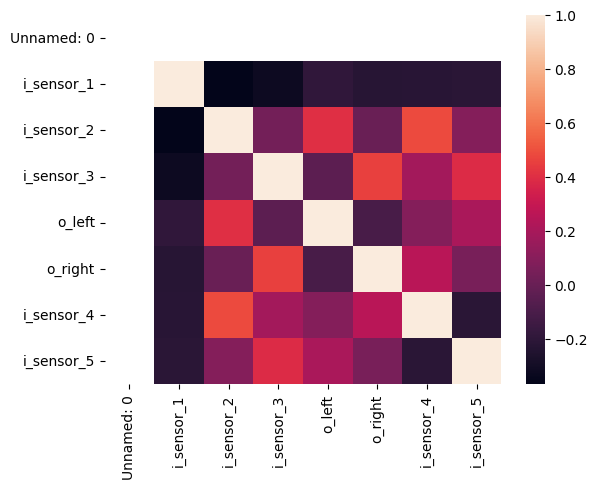

In [6]:
import seaborn as sns
sns.heatmap(df.corr())

# Scale/convert input values

In [7]:
df = df.astype({'o_left': int, 'o_right': int})   

In [8]:
df.head()

,Unnamed: 0,i_sensor_1,i_sensor_2,i_sensor_3,o_left,o_right,i_sensor_4,i_sensor_5
0,0,600,61,87,0,0,88.0,75.0
1,0,600,65,87,0,0,100.0,76.0
2,0,600,65,87,0,0,100.0,76.0
3,0,600,65,87,0,0,57.0,76.0
4,0,600,65,88,0,0,57.0,76.0


In [9]:
df[df['o_left']==1]

,Unnamed: 0,i_sensor_1,i_sensor_2,i_sensor_3,o_left,o_right,i_sensor_4,i_sensor_5
16,0,600,76,69,1,0,63.0,66.0
20,0,600,73,69,1,0,65.0,62.0
118,0,120,200,72,1,0,73.0,63.0
119,0,121,200,79,1,0,73.0,64.0
120,0,120,200,87,1,0,72.0,66.0
...,...,...,...,...,...,...,...,...
1784,0,600,53,61,1,0,47.0,58.0
1806,0,243,64,41,1,0,64.0,46.0
1895,0,600,66,81,1,0,55.0,74.0
1913,0,600,65,74,1,0,56.0,64.0


# Set Train and test 

In [10]:
from sklearn.model_selection import train_test_split
X = df.drop(['o_left','o_right','Unnamed: 0'],axis=1).values
y = df[['o_left','o_right']].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=101)

# Create neural network

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [12]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
model = Sequential()
X_train.shape

(2998, 5)

In [13]:
model.add(Dense(units=8, input_dim=5,activation='relu'))

model.add(Dense(units=10,activation='relu'))

model.add(Dense(units=10,activation='relu'))

model.add(Dense(units=10,activation='relu'))

model.add(Dense(2,activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model

In [15]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=800,
          validation_data=(X_test, y_test), verbose=1
          )

Epoch 1/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2146 - accuracy: 0.6688 - val_loss: 0.2560 - val_accuracy: 0.5362
Epoch 2/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2146 - accuracy: 0.6734 - val_loss: 0.2581 - val_accuracy: 0.8241
Epoch 3/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2140 - accuracy: 0.7065 - val_loss: 0.2564 - val_accuracy: 0.7984
Epoch 4/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2126 - accuracy: 0.6428 - val_loss: 0.2525 - val_accuracy: 0.8770
Epoch 5/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2120 - accuracy: 0.7118 - val_loss: 0.2549 - val_accuracy: 0.8646
Epoch 6/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2138 - accuracy: 0.7372 - val_loss: 0.2616 - val_accuracy: 0.6428
Epoch 7/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2180 - accuracy: 0.7302 - val_loss: 0.2637 - val_accuracy: 0.7907
Epoch 8/800
9

Epoch 59/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2135 - accuracy: 0.6734 - val_loss: 0.2603 - val_accuracy: 0.5673
Epoch 60/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2146 - accuracy: 0.6798 - val_loss: 0.2565 - val_accuracy: 0.7977
Epoch 61/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2133 - accuracy: 0.7061 - val_loss: 0.2670 - val_accuracy: 0.7930
Epoch 62/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2149 - accuracy: 0.7041 - val_loss: 0.2645 - val_accuracy: 0.5774
Epoch 63/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2117 - accuracy: 0.7185 - val_loss: 0.2530 - val_accuracy: 0.6973
Epoch 64/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2126 - accuracy: 0.6624 - val_loss: 0.2569 - val_accuracy: 0.5362
Epoch 65/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2125 - accuracy: 0.6908 - val_loss: 0.2536 - val_accuracy: 0.8661
Epoch 

94/94 [==============================] - 0s 1ms/step - loss: 0.2119 - accuracy: 0.7001 - val_loss: 0.2689 - val_accuracy: 0.4918
Epoch 117/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2120 - accuracy: 0.6731 - val_loss: 0.2642 - val_accuracy: 0.7035
Epoch 118/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2109 - accuracy: 0.6738 - val_loss: 0.2627 - val_accuracy: 0.8630
Epoch 119/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2110 - accuracy: 0.6821 - val_loss: 0.2671 - val_accuracy: 0.8708
Epoch 120/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2137 - accuracy: 0.7118 - val_loss: 0.2681 - val_accuracy: 0.7370
Epoch 121/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2111 - accuracy: 0.6571 - val_loss: 0.2638 - val_accuracy: 0.7588
Epoch 122/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2129 - accuracy: 0.6528 - val_loss: 0.2665 - val_accuracy: 0.7883
Epoch 123/800

94/94 [==============================] - 0s 1ms/step - loss: 0.2101 - accuracy: 0.6801 - val_loss: 0.2845 - val_accuracy: 0.8405
Epoch 174/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2131 - accuracy: 0.6634 - val_loss: 0.2640 - val_accuracy: 0.8241
Epoch 175/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2112 - accuracy: 0.6998 - val_loss: 0.2649 - val_accuracy: 0.4109
Epoch 176/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2110 - accuracy: 0.6114 - val_loss: 0.2671 - val_accuracy: 0.8374
Epoch 177/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2113 - accuracy: 0.6798 - val_loss: 0.2619 - val_accuracy: 0.8506
Epoch 178/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2129 - accuracy: 0.7332 - val_loss: 0.2601 - val_accuracy: 0.8117
Epoch 179/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2110 - accuracy: 0.6381 - val_loss: 0.2640 - val_accuracy: 0.6700
Epoch 180/800

94/94 [==============================] - 0s 1ms/step - loss: 0.2115 - accuracy: 0.6157 - val_loss: 0.2651 - val_accuracy: 0.8918
Epoch 231/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2118 - accuracy: 0.7018 - val_loss: 0.2637 - val_accuracy: 0.7043
Epoch 232/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2109 - accuracy: 0.6501 - val_loss: 0.2661 - val_accuracy: 0.8903
Epoch 233/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2103 - accuracy: 0.7345 - val_loss: 0.2655 - val_accuracy: 0.6039
Epoch 234/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2086 - accuracy: 0.6678 - val_loss: 0.2670 - val_accuracy: 0.6148
Epoch 235/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2118 - accuracy: 0.7442 - val_loss: 0.2714 - val_accuracy: 0.7292
Epoch 236/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2107 - accuracy: 0.6805 - val_loss: 0.2661 - val_accuracy: 0.7089
Epoch 237/800

94/94 [==============================] - 0s 1ms/step - loss: 0.2077 - accuracy: 0.6571 - val_loss: 0.2676 - val_accuracy: 0.8957
Epoch 288/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2085 - accuracy: 0.7138 - val_loss: 0.2653 - val_accuracy: 0.4685
Epoch 289/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2110 - accuracy: 0.6694 - val_loss: 0.2650 - val_accuracy: 0.5144
Epoch 290/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2113 - accuracy: 0.6748 - val_loss: 0.2645 - val_accuracy: 0.7268
Epoch 291/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2101 - accuracy: 0.7061 - val_loss: 0.2621 - val_accuracy: 0.6086
Epoch 292/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2083 - accuracy: 0.6748 - val_loss: 0.2646 - val_accuracy: 0.8529
Epoch 293/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2101 - accuracy: 0.6808 - val_loss: 0.2662 - val_accuracy: 0.8825
Epoch 294/800

94/94 [==============================] - 0s 1ms/step - loss: 0.2107 - accuracy: 0.6464 - val_loss: 0.2712 - val_accuracy: 0.4521
Epoch 345/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2092 - accuracy: 0.7165 - val_loss: 0.2695 - val_accuracy: 0.5019
Epoch 346/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2093 - accuracy: 0.6761 - val_loss: 0.2695 - val_accuracy: 0.8514
Epoch 347/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2097 - accuracy: 0.6654 - val_loss: 0.2706 - val_accuracy: 0.7455
Epoch 348/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2084 - accuracy: 0.6811 - val_loss: 0.2663 - val_accuracy: 0.4716
Epoch 349/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2094 - accuracy: 0.6668 - val_loss: 0.2670 - val_accuracy: 0.3767
Epoch 350/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2086 - accuracy: 0.6348 - val_loss: 0.2792 - val_accuracy: 0.6093
Epoch 351/800

94/94 [==============================] - 0s 1ms/step - loss: 0.2089 - accuracy: 0.7125 - val_loss: 0.2659 - val_accuracy: 0.3354
Epoch 402/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2085 - accuracy: 0.6468 - val_loss: 0.2725 - val_accuracy: 0.8848
Epoch 403/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2091 - accuracy: 0.7061 - val_loss: 0.2671 - val_accuracy: 0.7183
Epoch 404/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2115 - accuracy: 0.7538 - val_loss: 0.2607 - val_accuracy: 0.8615
Epoch 405/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2093 - accuracy: 0.6698 - val_loss: 0.2666 - val_accuracy: 0.8358
Epoch 406/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2079 - accuracy: 0.6815 - val_loss: 0.2713 - val_accuracy: 0.8646
Epoch 407/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2124 - accuracy: 0.6021 - val_loss: 0.2713 - val_accuracy: 0.8506
Epoch 408/800

94/94 [==============================] - 0s 1ms/step - loss: 0.2103 - accuracy: 0.6354 - val_loss: 0.2703 - val_accuracy: 0.7074
Epoch 459/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2085 - accuracy: 0.6948 - val_loss: 0.2636 - val_accuracy: 0.8389
Epoch 460/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2084 - accuracy: 0.6744 - val_loss: 0.2626 - val_accuracy: 0.8280
Epoch 461/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2120 - accuracy: 0.7001 - val_loss: 0.2592 - val_accuracy: 0.7696
Epoch 462/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2097 - accuracy: 0.6891 - val_loss: 0.2637 - val_accuracy: 0.4016
Epoch 463/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2088 - accuracy: 0.6544 - val_loss: 0.2638 - val_accuracy: 0.4412
Epoch 464/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2082 - accuracy: 0.6458 - val_loss: 0.2608 - val_accuracy: 0.8101
Epoch 465/800

94/94 [==============================] - 0s 1ms/step - loss: 0.2061 - accuracy: 0.6101 - val_loss: 0.2744 - val_accuracy: 0.8747
Epoch 516/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2094 - accuracy: 0.6751 - val_loss: 0.2723 - val_accuracy: 0.3634
Epoch 517/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2094 - accuracy: 0.6658 - val_loss: 0.2709 - val_accuracy: 0.8599
Epoch 518/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2087 - accuracy: 0.6344 - val_loss: 0.2637 - val_accuracy: 0.8654
Epoch 519/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2077 - accuracy: 0.7332 - val_loss: 0.2748 - val_accuracy: 0.3245
Epoch 520/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2103 - accuracy: 0.6721 - val_loss: 0.2621 - val_accuracy: 0.5743
Epoch 521/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2083 - accuracy: 0.6308 - val_loss: 0.2655 - val_accuracy: 0.4078
Epoch 522/800

94/94 [==============================] - 0s 1ms/step - loss: 0.2080 - accuracy: 0.6931 - val_loss: 0.2568 - val_accuracy: 0.8553
Epoch 573/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2060 - accuracy: 0.6221 - val_loss: 0.2627 - val_accuracy: 0.3922
Epoch 574/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2088 - accuracy: 0.6768 - val_loss: 0.2660 - val_accuracy: 0.7525
Epoch 575/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2078 - accuracy: 0.6194 - val_loss: 0.2668 - val_accuracy: 0.7471
Epoch 576/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2092 - accuracy: 0.6551 - val_loss: 0.2629 - val_accuracy: 0.8568
Epoch 577/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2075 - accuracy: 0.6911 - val_loss: 0.2564 - val_accuracy: 0.8623
Epoch 578/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2077 - accuracy: 0.6668 - val_loss: 0.2605 - val_accuracy: 0.4607
Epoch 579/800

94/94 [==============================] - 0s 1ms/step - loss: 0.2077 - accuracy: 0.5897 - val_loss: 0.2590 - val_accuracy: 0.8304
Epoch 630/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2050 - accuracy: 0.6278 - val_loss: 0.2592 - val_accuracy: 0.8965
Epoch 631/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2085 - accuracy: 0.6521 - val_loss: 0.2581 - val_accuracy: 0.7214
Epoch 632/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2077 - accuracy: 0.6247 - val_loss: 0.2596 - val_accuracy: 0.9004
Epoch 633/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2083 - accuracy: 0.6865 - val_loss: 0.2673 - val_accuracy: 0.4187
Epoch 634/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2087 - accuracy: 0.6895 - val_loss: 0.2563 - val_accuracy: 0.5798
Epoch 635/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2065 - accuracy: 0.6788 - val_loss: 0.2573 - val_accuracy: 0.8607
Epoch 636/800

94/94 [==============================] - 0s 1ms/step - loss: 0.2072 - accuracy: 0.6584 - val_loss: 0.2503 - val_accuracy: 0.6630
Epoch 687/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2070 - accuracy: 0.6448 - val_loss: 0.2522 - val_accuracy: 0.3774
Epoch 688/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2061 - accuracy: 0.7075 - val_loss: 0.2533 - val_accuracy: 0.8591
Epoch 689/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2081 - accuracy: 0.6744 - val_loss: 0.2503 - val_accuracy: 0.7774
Epoch 690/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2103 - accuracy: 0.6554 - val_loss: 0.2512 - val_accuracy: 0.8490
Epoch 691/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2075 - accuracy: 0.6408 - val_loss: 0.2512 - val_accuracy: 0.4560
Epoch 692/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2073 - accuracy: 0.6224 - val_loss: 0.2422 - val_accuracy: 0.7774
Epoch 693/800

94/94 [==============================] - 0s 1ms/step - loss: 0.2070 - accuracy: 0.6815 - val_loss: 0.2542 - val_accuracy: 0.6529
Epoch 744/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2065 - accuracy: 0.6678 - val_loss: 0.2519 - val_accuracy: 0.3455
Epoch 745/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2061 - accuracy: 0.6755 - val_loss: 0.2567 - val_accuracy: 0.5588
Epoch 746/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2071 - accuracy: 0.7278 - val_loss: 0.2587 - val_accuracy: 0.3611
Epoch 747/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2052 - accuracy: 0.6438 - val_loss: 0.2555 - val_accuracy: 0.6420
Epoch 748/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2050 - accuracy: 0.6551 - val_loss: 0.2572 - val_accuracy: 0.8467
Epoch 749/800
94/94 [==============================] - 0s 1ms/step - loss: 0.2066 - accuracy: 0.6755 - val_loss: 0.2470 - val_accuracy: 0.7767
Epoch 750/800

94/94 [==============================] - 0s 1ms/step - loss: 0.2054 - accuracy: 0.6975 - val_loss: 0.2565 - val_accuracy: 0.8490


In [16]:
model_loss = pd.DataFrame(model.history.history)

<AxesSubplot:>

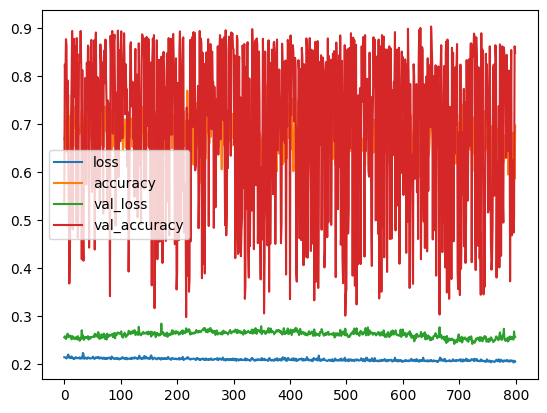

In [17]:
model_loss.plot()

In [18]:
model.save('car_game_model.h5')

In [19]:
import keras
model = keras.models.load_model('car_game_model.h5')

In [ ]:
from car_game.car_game import CarGame
from car_game.road_enum import RoadEnum
    
car_game = CarGame(screen_size=(1920, 1080), car_speed=6, frame_rate=60,
                   road=RoadEnum.THREE, sensor_threshold=200, generate_train_data=False, nn_model=model)

car_game.start_game()


1/1 [==============================] - 0s 45ms/step
{'i_sensor_1': 600, 'i_sensor_2': 61, 'i_sensor_3': 92, 'i_sensor_4': 200, 'i_sensor_5': 77}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 600, 'i_sensor_2': 64, 'i_sensor_3': 88, 'i_sensor_4': 101, 'i_sensor_5': 77}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 600, 'i_sensor_2': 64, 'i_sensor_3': 88, 'i_sensor_4': 101, 'i_sensor_5': 77}
1/1 [==============================] - 0s 13ms/step
{'i_sensor_1': 600, 'i_sensor_2': 64, 'i_sensor_3': 88, 'i_sensor_4': 57, 'i_sensor_5': 77}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 600, 'i_sensor_2': 64, 'i_sensor_3': 89, 'i_sensor_4': 57, 'i_sensor_5': 77}
1/1 [==============================] - 0s 13ms/step
{'i_sensor_1': 600, 'i_sensor_2': 64, 'i_sensor_3': 88, 'i_sensor_4': 57, 'i_sensor_5': 77}
1/1 [==============================] - 0s 13ms/step
{'i_sensor_1': 600, 'i_sensor_2': 64, 'i_sensor_3': 85, 'i_sensor_4': 57, 'i_sens

1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 600, 'i_sensor_2': 67, 'i_sensor_3': 79, 'i_sensor_4': 60, 'i_sensor_5': 69}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 600, 'i_sensor_2': 67, 'i_sensor_3': 77, 'i_sensor_4': 61, 'i_sensor_5': 70}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 600, 'i_sensor_2': 67, 'i_sensor_3': 76, 'i_sensor_4': 61, 'i_sensor_5': 70}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 600, 'i_sensor_2': 67, 'i_sensor_3': 76, 'i_sensor_4': 61, 'i_sensor_5': 70}
1/1 [==============================] - 0s 13ms/step
{'i_sensor_1': 600, 'i_sensor_2': 66, 'i_sensor_3': 75, 'i_sensor_4': 61, 'i_sensor_5': 70}
1/1 [==============================] - 0s 14ms/step
{'i_sensor_1': 600, 'i_sensor_2': 66, 'i_sensor_3': 75, 'i_sensor_4': 61, 'i_sensor_5': 70}
1/1 [==============================] - 0s 13ms/step
{'i_sensor_1': 600, 'i_sensor_2': 66, 'i_sensor_3': 75, 'i_sensor_4': 60, 'i_sensor_

1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 179, 'i_sensor_2': 60, 'i_sensor_3': 78, 'i_sensor_4': 54, 'i_sensor_5': 69}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 173, 'i_sensor_2': 65, 'i_sensor_3': 80, 'i_sensor_4': 54, 'i_sensor_5': 69}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 167, 'i_sensor_2': 99, 'i_sensor_3': 80, 'i_sensor_4': 54, 'i_sensor_5': 69}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 171, 'i_sensor_2': 100, 'i_sensor_3': 85, 'i_sensor_4': 54, 'i_sensor_5': 69}
1/1 [==============================] - 0s 13ms/step
{'i_sensor_1': 161, 'i_sensor_2': 99, 'i_sensor_3': 94, 'i_sensor_4': 53, 'i_sensor_5': 72}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 166, 'i_sensor_2': 58, 'i_sensor_3': 98, 'i_sensor_4': 53, 'i_sensor_5': 75}
1/1 [==============================] - 0s 13ms/step
{'i_sensor_1': 163, 'i_sensor_2': 100, 'i_sensor_3': 200, 'i_sensor_4': 51, 'i_sens

1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 237, 'i_sensor_2': 200, 'i_sensor_3': 47, 'i_sensor_4': 94, 'i_sensor_5': 37}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 234, 'i_sensor_2': 200, 'i_sensor_3': 47, 'i_sensor_4': 96, 'i_sensor_5': 34}
1/1 [==============================] - 0s 15ms/step
{'i_sensor_1': 226, 'i_sensor_2': 200, 'i_sensor_3': 43, 'i_sensor_4': 97, 'i_sensor_5': 31}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 221, 'i_sensor_2': 200, 'i_sensor_3': 42, 'i_sensor_4': 98, 'i_sensor_5': 31}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 214, 'i_sensor_2': 200, 'i_sensor_3': 43, 'i_sensor_4': 99, 'i_sensor_5': 30}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 210, 'i_sensor_2': 200, 'i_sensor_3': 42, 'i_sensor_4': 100, 'i_sensor_5': 30}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 203, 'i_sensor_2': 200, 'i_sensor_3': 43, 'i_sensor_4': 101, '

1/1 [==============================] - 0s 13ms/step
{'i_sensor_1': 300, 'i_sensor_2': 200, 'i_sensor_3': 25, 'i_sensor_4': 100, 'i_sensor_5': 11}
1/1 [==============================] - 0s 11ms/step
{'i_sensor_1': 298, 'i_sensor_2': 200, 'i_sensor_3': 28, 'i_sensor_4': 101, 'i_sensor_5': 12}
1/1 [==============================] - 0s 11ms/step
{'i_sensor_1': 291, 'i_sensor_2': 200, 'i_sensor_3': 29, 'i_sensor_4': 100, 'i_sensor_5': 12}
1/1 [==============================] - 0s 11ms/step
{'i_sensor_1': 286, 'i_sensor_2': 200, 'i_sensor_3': 29, 'i_sensor_4': 101, 'i_sensor_5': 13}
1/1 [==============================] - 0s 13ms/step
{'i_sensor_1': 279, 'i_sensor_2': 200, 'i_sensor_3': 28, 'i_sensor_4': 100, 'i_sensor_5': 14}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 274, 'i_sensor_2': 200, 'i_sensor_3': 30, 'i_sensor_4': 101, 'i_sensor_5': 15}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 267, 'i_sensor_2': 200, 'i_sensor_3': 31, 'i_sensor_4': 1

1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 224, 'i_sensor_2': 61, 'i_sensor_3': 90, 'i_sensor_4': 52, 'i_sensor_5': 80}
1/1 [==============================] - 0s 11ms/step
{'i_sensor_1': 218, 'i_sensor_2': 61, 'i_sensor_3': 89, 'i_sensor_4': 51, 'i_sensor_5': 80}
1/1 [==============================] - 0s 11ms/step
{'i_sensor_1': 212, 'i_sensor_2': 61, 'i_sensor_3': 87, 'i_sensor_4': 51, 'i_sensor_5': 80}
1/1 [==============================] - 0s 11ms/step
{'i_sensor_1': 206, 'i_sensor_2': 62, 'i_sensor_3': 86, 'i_sensor_4': 51, 'i_sensor_5': 80}
1/1 [==============================] - 0s 12ms/step
{'i_sensor_1': 200, 'i_sensor_2': 62, 'i_sensor_3': 84, 'i_sensor_4': 51, 'i_sensor_5': 80}
1/1 [==============================] - 0s 11ms/step
{'i_sensor_1': 194, 'i_sensor_2': 73, 'i_sensor_3': 83, 'i_sensor_4': 51, 'i_sensor_5': 80}
1/1 [==============================] - 0s 11ms/step
{'i_sensor_1': 204, 'i_sensor_2': 70, 'i_sensor_3': 84, 'i_sensor_4': 51, 'i_sensor_